# Kaggle: Housing Prices

Kaggle housing prices challenge in Julia.  
This is an attempt to complete the kaggle housing prices challenge, described [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), with the Julia language.

I do not have any experience with Julia, so I'm relying on tutorials that can be found on [JuliaBox](https://juliabox.com/) to guide me in data processing, plotting, and analysis ([here](https://github.com/JuliaComputing/JuliaBoxTutorials/blob/master/introductory-tutorials/broader-topics-and-ecosystem) they are on GitHub).  
This will mirror other work that I have tried for this challenge that uses Python (with which I'm much more familiar).

This notebook is a continuation of the notebooks featured in the figment `python/` directory.  Here, we explore the same Kaggle [challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques),
but we are using `Julia` instead of `python`!

I'll refer you to the python notebooks for the exploratory analysis.  For this notebook, I will mostly be playing around with `Julia` (trying to learn it) and specifically, the `Flux` module.

_When it occurs, I will try to put links to blogs/stackoverflow for code I need to lookup_

To get started, let's clone the repository into JuliaBox so that we have access to the data.

_Using the 'terminal' from JuliaBox, it is possible to clone the repository into your account and then work from the notebook within the repository directly!_

```
cd /home/jrun
git clone https://github.com/yourname/figment.git
cp -R /home/jrun/figment /mnt/juliabox
```

Then you can load this notebook directly from the repo.

First, let's load some modules that we will use.

In [1]:
# If necessary, add the relevant packages
import Pkg
# Pkg.add("DataFrames")  # to access a module if it isn't available

In [2]:
using Flux           # ML library
using Flux: throttle # reduce std::output
using Flux: @epochs  # train with epochs
using DataFrames     # handling data
using PyPlot         # plotting library with which I'm very familiar (...baby steps)
using CSV            # reading csv file
using Statistics     # correlation matrix calculation
using Missings       # handling missing datatypes
using Nullables      # handling String->Float conversion with "NA"

loaded


The data is stored in this local repository, so let's access it and start looking at it!

_NB: I couldn't get `readcsv` to work, so I'm using the CSV module instead_

In [3]:
df = CSV.File("../data/train.csv") |> DataFrame

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,Int64⍰,Int64⍰,String⍰,String⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,Int64⍰,String⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,Int64⍰
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,W

Following what I learned in the Python notebooks, let's calculate the correlation matrix and then choose a subset of features that are "strongly" correlated with `SalePrice`, then try to make predictions!

Before converting the dataframe to an array for the different calculations we need to do, let's remove the columns that have text data.

(https://stackoverflow.com/questions/52205663/select-numerical-columns-of-julia-dataframe-with-missing-values)

In [4]:
text_data = df[[i for i in names(df) if Base.nonmissingtype(eltype(df[i])) <: String]];
num_dat   = df[[i for i in names(df) if Base.nonmissingtype(eltype(df[i])) <: Number]]

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
3,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
4,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
5,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
6,6,50,14115,5,5,1993,1995,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,2,480,40,30,0,320,0,0,700,10,2009,143000
7,7,20,10084,8,5,2004,2005,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2,636,255,57,0,0,0,0,0,8,2007,307000
8,8,60,10382,7,6,1973,1973,859,32,216,1107,1107,983,0,2090,1,0,2,1,3,1,7,2,2,484,235,204,228,0,0,0,350,11,2009,200000
9,9,50,6120,7,5,1931,1950,0,0,952,952,1022,752,0,1774,0,0,2,0,2,2,8,2,2,468,90,0,205,0,0,0,0,4,2008,129900


In [5]:
col_names = names(num_dat)
df_array  = convert(Array, num_dat)

# possible issue with missing values
# convert them: NaN -> -1 (as we did in the python example)
df_array  = collect(Missings.replace(df_array, -1))

1460×35 Array{Int64,2}:
    1   60   8450  7  5  2003  2003  …    0    0  0     0   2  2008  208500
    2   20   9600  6  8  1976  1976       0    0  0     0   5  2007  181500
    3   60  11250  7  5  2001  2002       0    0  0     0   9  2008  223500
    4   70   9550  7  5  1915  1970       0    0  0     0   2  2006  140000
    5   60  14260  8  5  2000  2000       0    0  0     0  12  2008  250000
    6   50  14115  5  5  1993  1995  …  320    0  0   700  10  2009  143000
    7   20  10084  8  5  2004  2005       0    0  0     0   8  2007  307000
    8   60  10382  7  6  1973  1973       0    0  0   350  11  2009  200000
    9   50   6120  7  5  1931  1950       0    0  0     0   4  2008  129900
   10  190   7420  5  6  1939  1950       0    0  0     0   1  2008  118000
   11   20  11200  5  5  1965  1965  …    0    0  0     0   2  2008  129500
   12   60  11924  9  5  2005  2006       0    0  0     0   7  2006  345000
   13   20  12968  5  6  1962  1962       0  176  0     0   9  2

Now we can calculate the correlation matrix, extract the most strongly correlated features with `SalePrice`, and then make some predictions!

In [6]:
corrmat = cor(df_array)

35×35 Array{Float64,2}:
  1.0           0.0111565   -0.0332255   …   0.000711794  -0.0219167
  0.0111565     1.0         -0.139781       -0.021407     -0.0842841
 -0.0332255    -0.139781     1.0            -0.0142614     0.263843 
 -0.0283648     0.0326277    0.105806       -0.0273467     0.790982 
  0.0126089    -0.0593158   -0.00563627      0.0439497    -0.0778559
 -0.0127127     0.0278501    0.0142277   …  -0.0136177     0.522897 
 -0.0219976     0.040581     0.0137884       0.0357432     0.507101 
 -0.00502405   -0.0698357    0.214103        0.0143589     0.38642  
 -0.00596767   -0.0656486    0.11117         0.0317056    -0.0113781
 -0.0079397    -0.140759    -0.00261836     -0.0412582     0.214479 
 -0.0154146    -0.238518     0.260833    …  -0.0149686     0.613581 
  0.010496     -0.251758     0.299475       -0.0136038     0.605852 
  0.00558985    0.307886     0.0509859      -0.0286999     0.319334 
  ⋮                                      ⋱                          
  0.016569

Now we'll plot the correlation matrix using `PyPlot`

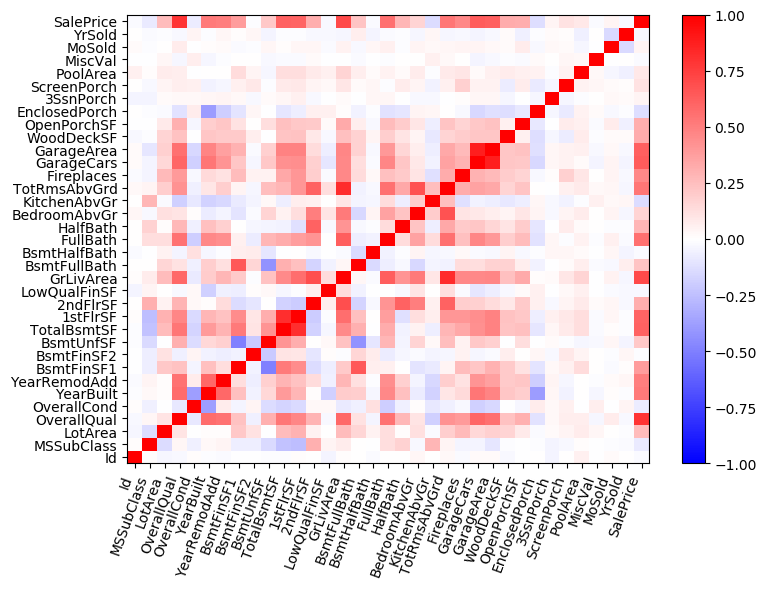

In [7]:
fig = figure("corrmat",figsize=(8,6)) 
ax  = gca()

#opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = pcolor(corrmat,cmap="bwr",vmin=-1,vmax=1)
cbar    = colorbar(heatmap, ax=ax)

# shift location of ticks to center of the bins
ax[:set_xticklabels](col_names, fontsize=10, minor=0, ha="right", rotation=70)
ax[:set_yticklabels](col_names, fontsize=10, minor=0)
ax[:set_xticks]([i-0.5 for i in 1:length(col_names)], minor=false); # set the ticks in the middle of the bin
ax[:set_yticks]([i-0.5 for i in 1:length(col_names)], minor=false); #   so the label goes in the 'right' spot

fig[:canvas][:draw]() 
PyPlot.tight_layout()

The values with the strongest correlations:

In [8]:
# Messing around with loops and confirming the index of sale price
sp_index = -1
for i in enumerate(col_names)
    index = i[1]
    name  = i[2]
    if String(name)=="SalePrice"
        sp_index = index
        println("Sale price is $sp_index ($index)")
    end
end


# Get the more strongly correlated features
sale_price   = corrmat[sp_index,:]
strong_corrs = []
for i in enumerate(sale_price)
    index = i[1]
    value = i[2]
    if value<-0.25 || (value>0.25 && value<1) # exclude `SalePrice` which has corr=1
        push!(strong_corrs,index) 
    end
end

sp_array = sale_price[strong_corrs]
sp_corrnames = col_names[strong_corrs]

Sale price is 35 (35)


17-element Array{Symbol,1}:
 :LotArea          
 :OverallQual      
 :YearBuilt        
 :YearRemodAdd     
 :BsmtFinSF1       
 :TotalBsmtSF      
 Symbol("1stFlrSF")
 Symbol("2ndFlrSF")
 :GrLivArea        
 :FullBath         
 :HalfBath         
 :TotRmsAbvGrd     
 :Fireplaces       
 :GarageCars       
 :GarageArea       
 :WoodDeckSF       
 :OpenPorchSF      

In [34]:
# LotFrontage     0.351799
# MasVnrArea      0.477493
# GarageYrBlt     0.486362
# map(x->(v = tryparse(Float64,x); ismissing(v) ? 0.0 : get(v)),text_data[:MasVnrArea])
strvec = ["1.2","NA","-1e3"]
map(x->(v = tryparse(Float64,x); isnull(v) ? -1 : v),strvec)

3-element Array{Union{Nothing, Float64},1}:
     1.2     
      nothing
 -1000.0     

In [37]:
a = tryparse(Float64,"NA")
isnull(a)

false

With the data accessed, let's now look at using Flux to make some predictions.

Normally I would look into simpler methods first, but because I've already done that using Python, I will just skip it for now and come back to it later if I find time.
[Here](https://github.com/JuliaComputing/JuliaBoxTutorials/blob/master/introductory-tutorials/broader-topics-and-ecosystem/intro-to-julia-for-data-science/2.%20Julia%20for%20Data%20Science%20-%20Algorithms.ipynb) is a great reference for checking non-Flux methods.

And [here](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl) is the MNIST example from Flux.

In [9]:
df_reduced = df[sp_corrnames]

,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,8450,7,2003,2003,706,856,856,854,1710,2,1,8,0,2,548,0,61
2,9600,6,1976,1976,978,1262,1262,0,1262,2,0,6,1,2,460,298,0
3,11250,7,2001,2002,486,920,920,866,1786,2,1,6,1,2,608,0,42
4,9550,7,1915,1970,216,756,961,756,1717,1,0,7,1,3,642,0,35
5,14260,8,2000,2000,655,1145,1145,1053,2198,2,1,9,1,3,836,192,84
6,14115,5,1993,1995,732,796,796,566,1362,1,1,5,0,2,480,40,30
7,10084,8,2004,2005,1369,1686,1694,0,1694,2,0,7,1,2,636,255,57
8,10382,7,1973,1973,859,1107,1107,983,2090,2,1,7,2,2,484,235,204
9,6120,7,1931,1950,0,952,1022,752,1774,2,0,8,2,2,468,90,0


In [10]:
# Split into testing and training sets
test_train_frac = 0.75
tot_entries     = length(df[:SalePrice])
n_entries       = convert(Int,(round(tot_entries*test_train_frac)))

Xtrain = convert(Array, df_reduced[1:n_entries,:]);
Xtrain = Xtrain'  # transpose for matrix multiplication
Xtest  = convert(Array, df_reduced[n_entries:tot_entries,:]);
Xtest  = Xtest'   # transpose for matrix multiplication
Ytrain = df[1:n_entries,:SalePrice];
Ytest  = df[n_entries:tot_entries,:SalePrice];

In [19]:
# Build the model 
model = Chain(
  Dense(17, 40, relu),
  Dense(40, 40, relu),
  Dense(40, 1)
)

Chain(Dense(17, 40, NNlib.relu), Dense(40, 40, NNlib.relu), Dense(40, 1))

In [24]:
n_epochs  = 200
loss(x,y) = Flux.mse(model(x), y)
optimizer = ADAM(params(model))
data      = repeated((Xtrain,Ytrain),n_epochs)
evalcb()  = @show(loss(Xtrain, Ytrain))

evalcb (generic function with 1 method)

In [25]:
# Train the model!
# - `throttle(f,N)` reduces printouts of function `f` to every `N` seconds
Flux.train!(loss, data, optimizer, cb = throttle(evalcb,1))

loss(Xtrain, Ytrain) = 3.870553257804387e13 (tracked)
loss(Xtrain, Ytrain) = 3.756193608175901e13 (tracked)
loss(Xtrain, Ytrain) = 3.637633153602248e13 (tracked)
loss(Xtrain, Ytrain) = 3.500308043436319e13 (tracked)
loss(Xtrain, Ytrain) = 3.3412541165346836e13 (tracked)
loss(Xtrain, Ytrain) = 3.1593560570419793e13 (tracked)
loss(Xtrain, Ytrain) = 2.9559710143518438e13 (tracked)
loss(Xtrain, Ytrain) = 2.73505912110144e13 (tracked)
loss(Xtrain, Ytrain) = 2.5044439752626914e13 (tracked)
loss(Xtrain, Ytrain) = 2.2996507873964477e13 (tracked)
loss(Xtrain, Ytrain) = 2.1033657414411645e13 (tracked)
loss(Xtrain, Ytrain) = 1.9245213137846656e13 (tracked)
loss(Xtrain, Ytrain) = 1.7710576618640266e13 (tracked)
loss(Xtrain, Ytrain) = 1.647453967164285e13 (tracked)
loss(Xtrain, Ytrain) = 1.5525208478506777e13 (tracked)
loss(Xtrain, Ytrain) = 1.4720211801842963e13 (tracked)
loss(Xtrain, Ytrain) = 1.4148253581975426e13 (tracked)
loss(Xtrain, Ytrain) = 1.3639996340615018e13 (tracked)
loss(Xtrain, Ytra

In [26]:
# Results & performance
prediction = convert(Array,model(Xtest).data)

1×366 Array{Float64,2}:
 1.18723e5  1.4474e5  1.2298e5  1.12951e5  …  1.60492e5  1.39345e5  1.57415e5

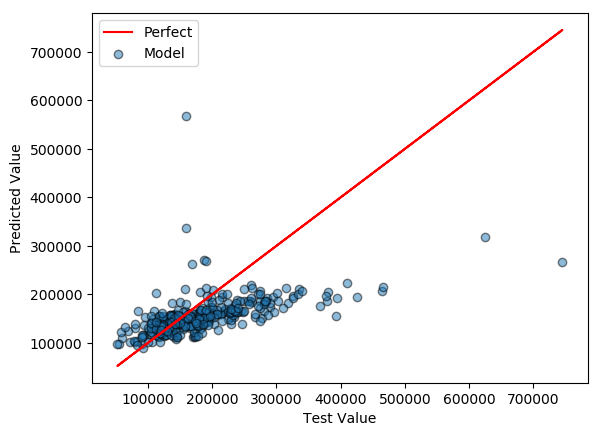

PyObject <matplotlib.legend.Legend object at 0x149af6c88>

In [27]:
plot(Ytest,Ytest,color="r",label="Perfect")
scatter(Ytest,prediction,alpha=0.5,edgecolor="k",label="Model")
xlabel("Test Value")
ylabel("Predicted Value")
legend()

### Scale the Inputs

From here we can see that the prediction is quite bad.  Let's scale the inputs and try again!

In [28]:
scale_μ  = mean(Xtest,dims=2)
scale_σ  = std(Xtest,dims=2)
tscale_μ = mean(Ytest,dims=1)
tscale_σ = std(Ytest,dims=1)

1-element Array{Float64,1}:
 78605.58854028353

In [30]:
scaler(x,μ,σ) = (x .- μ) ./ σ

scaler (generic function with 1 method)

In [31]:
Xtest_scale  = scaler(Xtest,scale_μ,scale_σ);
Xtrain_scale = scaler(Xtrain,scale_μ,scale_σ);
Ytest_scale  = scaler(Ytest,tscale_μ,tscale_σ);
Ytrain_scale = scaler(Ytrain,tscale_μ,tscale_σ);

In [33]:
Xtest_scale

17×366 Array{Float64,2}:
 -0.736501  -0.162366   -0.567706   …  -0.208143   -0.0957801  -0.059158
 -0.766554  -0.0397178  -0.0397178      0.687118   -0.766554   -0.766554
 -0.444494   1.15894    -1.79138       -0.925526   -0.636907   -0.155875
  0.757698   1.03986     1.03986        1.03986     0.56959    -0.888242
 -0.389326  -0.831784   -0.87919       -0.335994   -0.782403    0.760275
 -0.26214    0.526538   -0.787926   …   0.188533    0.0341357   0.405524
 -0.568353   0.344236   -0.961876       0.0400397  -0.225528    0.204209
 -0.812648  -0.812648    0.504552       1.79459    -0.812648   -0.812648
 -1.0513    -0.386339   -0.314214       1.41854    -0.801497   -0.488369
 -1.01233    0.77759    -1.01233        0.77759    -1.01233    -1.01233 
 -0.732152  -0.732152    1.19567    …  -0.732152   -0.732152    1.19567 
 -1.56438   -0.34616     0.262949       1.48117    -0.955269   -0.34616 
 -0.96544    0.584345   -0.96544        2.13413    -0.96544    -0.96544 
 -0.995334   0.296483   -2

In [54]:
# Build the model 
model_scale = Chain(
    Dense(17, 34, relu),
    Dense(34, 1)
)

Chain(Dense(17, 34, NNlib.relu), Dense(34, 1))

In [55]:
n_epochs = 200
loss_scale(x,y) = Flux.mse(model_scale(x), y)
optimizer_scale = ADAM(params(model_scale),0.01)
data_scale      = repeated((Xtrain_scale,Ytrain_scale),n_epochs)
evalcb_scale()  = @show(loss_scale(Xtrain_scale, Ytrain_scale))

evalcb_scale (generic function with 1 method)

In [56]:
# Train!
Flux.train!(loss_scale, data_scale, optimizer_scale, cb = throttle(evalcb_scale,1))

loss_scale(Xtrain_scale, Ytrain_scale) = 1526.739849716977 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1165.9515777405993 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1135.7830002935118 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1131.3920570228815 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1129.7010085002323 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1128.7743008617674 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1128.2236586946776 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1127.8060148282327 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1127.470261451701 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1127.216788304032 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1126.9939873840128 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1126.839621886785 (tracked)


In [47]:
# Results & performance
prediction = convert(Array,model_scale(Xtest_scale).data)

1×366 Array{Float64,2}:
 0.0394309  0.0148609  0.0628436  …  0.027134  0.0284024  0.0399967

In [52]:
train_pred = convert(Array,model_scale(Xtrain_scale).data)

1×1095 Array{Float64,2}:
 0.029731  0.0572528  -0.00518417  …  0.0465502  0.0312731  0.0309059

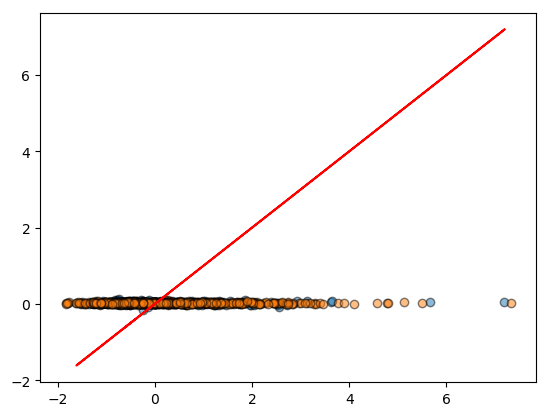

PyObject <matplotlib.collections.PathCollection object at 0x14ab17898>

In [53]:
plot(Ytest_scale,Ytest_scale,color="r")
scatter(Ytest_scale,prediction,alpha=0.5,edgecolor="k")
scatter(Ytrain_scale,train_pred,alpha=0.5,edgecolor="k")